In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

#%load_ext autoreload
#%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

In [3]:
import IPython.display as ipd

In [4]:
def all_exp(alpha, beta, tau, temp, mixtures, model_name, data_size="search"):
    ipd.display(ipd.Markdown("**Simple SWS**"))
    model_sws, gmp_sws, res_sws = retrain_model(alpha, beta, tau, int(0), mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_sws, means = list(gmp_sws.means.data.clone().cpu()), precisions = list(gmp_sws.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD**"))
    model_kd, gmp_kd, res_kd = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", False)
    show_sws_weights(model = model_kd, means = list(gmp_kd.means.data.clone().cpu()), precisions = list(gmp_kd.gammas.data.clone().cpu()))
    
    ipd.display(ipd.Markdown("**SWS KD Scaling**"))
    model_kd_s, gmp_kd_s, res_kd_s = retrain_model(alpha, beta, tau, temp, mixtures, model_name, data_size, "", True)
    show_sws_weights(model = model_kd_s, means = list(gmp_kd_s.means.data.clone().cpu()), precisions = list(gmp_kd_s.gammas.data.clone().cpu()))
    
    title = "Mean: {} Var: {}\n".format(alpha/beta, alpha/(beta**2))
    sws_res = "Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n".format(res_sws['compress_test'], res_sws['compress_val'], res_sws['prune_test'], res_sws['prune_val'], res_sws['sparsity'])
    kd_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n'.format(res_kd['compress_test'], res_kd['compress_val'], res_kd['prune_test'], res_kd['prune_val'], res_kd['sparsity'])
    kd_s_res = 'Retrain Test: {:.2f}, Retrain Validation: {:.2f}, Prune Test: {:.2f}, Prune Validation: {:.2f}, Prune Sparsity: {:.2f}\n\n'.format(res_kd_s['compress_test'], res_kd_s['compress_val'], res_kd_s['prune_test'], res_kd_s['prune_val'], res_kd_s['sparsity'])
    res_str = title + sws_res + kd_res + kd_s_res
    print (res_str)
    
    return model_sws, gmp_sws, model_kd, gmp_kd, model_kd_s, gmp_kd_s, res_str

### Load good hyperparameters

In [5]:
with open("../search/sobol_search.p", "rb") as handle:
    params = pickle.load(handle)
i = 240
print ("exp:{} mean: {}, var: {}, tau: {}, temp: {}, mixtures: {}".format(i, params['mean'][i], params['var'][i], params['tau'][i], params['temp'][i], int(params['mixtures'][i])))
mean = float(params['mean'][i])
var = float(params['var'][i])
tau = float(params['tau'][i])
mixtures = int(params['mixtures'][i])
temp = float(params['temp'][i])
model_name = 'LeNet_300_100'
data_size = 'search'

exp:240 mean: 0.10181517217181825, var: 0.1034304555503225, tau: 6.479230606842127e-07, temp: 19.0, mixtures: 9


### Override Parameters

In [10]:
mixtures = 15
temp = 4
mean = 10
var = 10
beta = mean/var
alpha = mean * beta

**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.24
Epoch: 20. Test Accuracy: 97.36
Epoch: 30. Test Accuracy: 97.54
Epoch: 40. Test Accuracy: 97.69
Epoch: 50. Test Accuracy: 97.59
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25


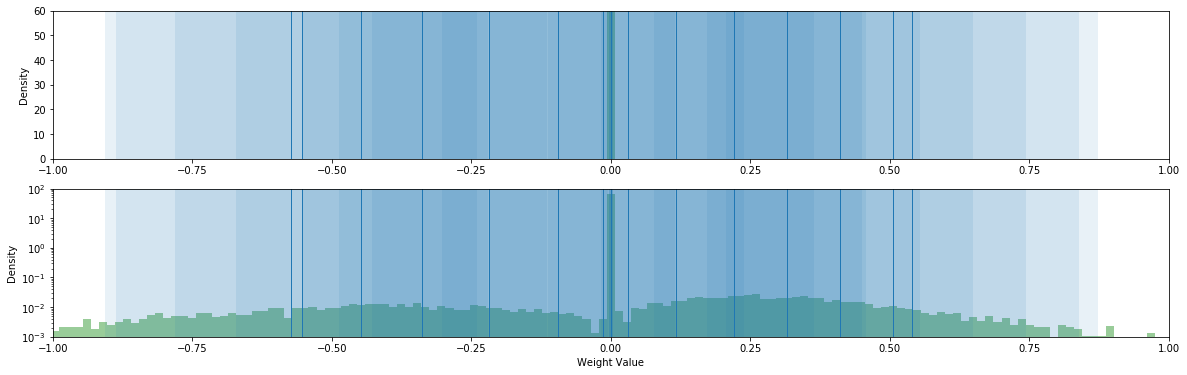

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.83
Epoch: 20. Test Accuracy: 98.12
Epoch: 30. Test Accuracy: 98.03
Epoch: 40. Test Accuracy: 98.03
Epoch: 50. Test Accuracy: 97.97
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33


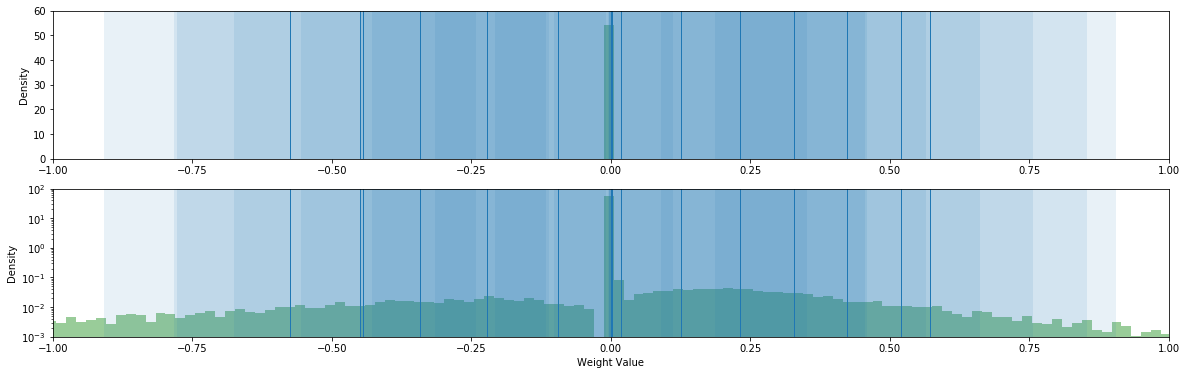

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.49
Epoch: 20. Test Accuracy: 98.08
Epoch: 30. Test Accuracy: 98.10
Epoch: 40. Test Accuracy: 98.02
Epoch: 50. Test Accuracy: 98.07
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20


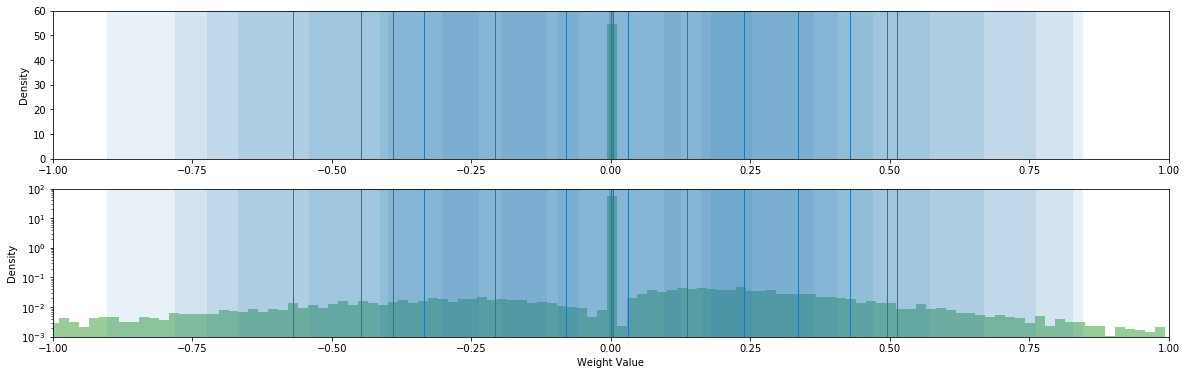

Mean: 10.0 Var: 10.0
Retrain Test: 97.59, Retrain Validation: 0.00, Prune Test: 96.66, Prune Validation: 0.00, Prune Sparsity: 98.25
Retrain Test: 97.97, Retrain Validation: 0.00, Prune Test: 97.16, Prune Validation: 0.00, Prune Sparsity: 97.33
Retrain Test: 98.07, Retrain Validation: 0.00, Prune Test: 97.49, Prune Validation: 0.00, Prune Sparsity: 97.20




<IPython.core.display.Javascript object>

In [11]:
%%notify
_, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name, data_size = 'full')

**Simple SWS**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 91.44
Terminating Search - Epoch: 17 - Val Acc: 29.75
Retrain Test: 30.49, Retrain Validation: 29.75, Prune Test: 20.34, Prune Validation: 19.62, Prune Sparsity: 99.93


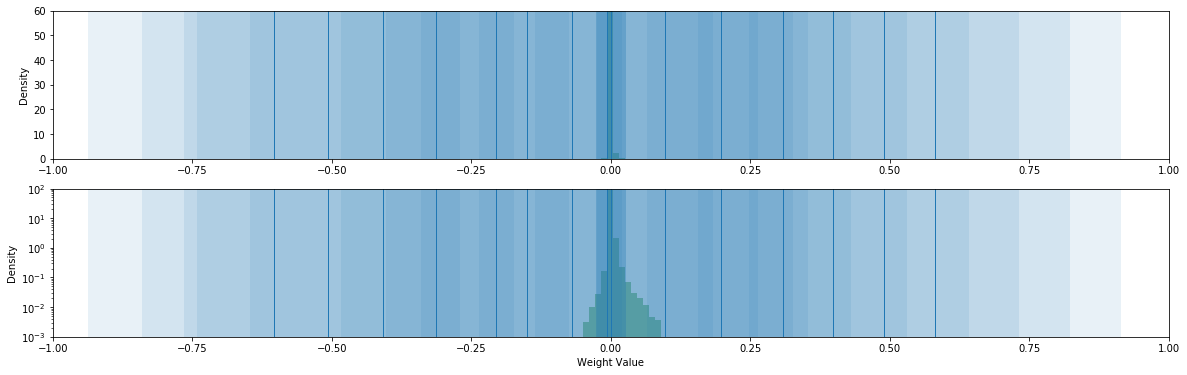

**SWS KD**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 94.74
Epoch: 20. Test Accuracy: 86.31
Epoch: 30. Test Accuracy: 79.59
Epoch: 40. Test Accuracy: 77.41
Epoch: 50. Test Accuracy: 78.86
Retrain Test: 78.86, Retrain Validation: 78.74, Prune Test: 19.85, Prune Validation: 20.53, Prune Sparsity: 99.94


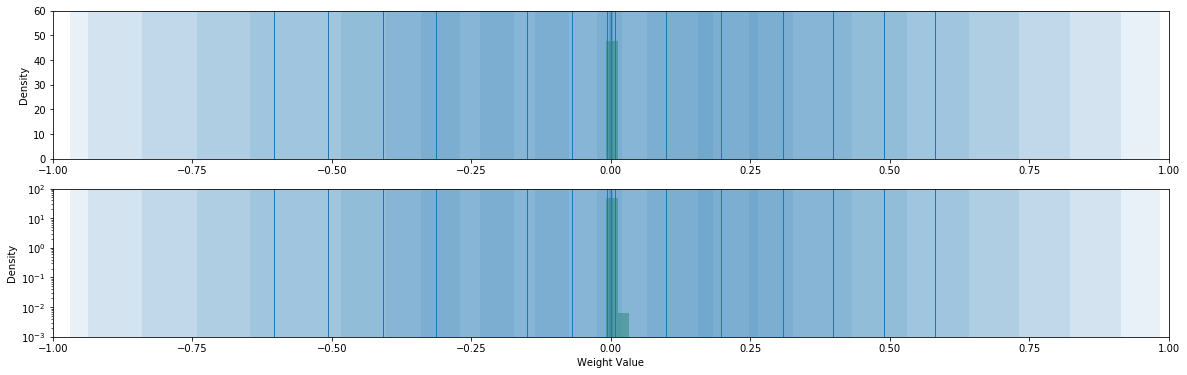

**SWS KD Scaling**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 10.0 Variance: 10.0
Epoch: 10. Test Accuracy: 96.09
Epoch: 20. Test Accuracy: 86.94


In [ ]:
%%notify
res_str = ""
for temp in [1, 2, 4, 10, 20]:
    for tau in [1e-4, 1e-5, 1e-6]:
        _, _, _, _, _, _, res = all_exp(alpha, beta, tau, temp, mixtures, model_name)
        res_str = res_str + res
print (res_str)